# Challenge: Edit MNIST challenge images to be correctly predicted

Goal: Edit the images placed in `data/MNIST/challenge` so that the provided model predicts the correct label while keeping more than 60% of the original pixels unchanged.

Description: You are given a pre-trained `SmallCNN` model and a small set of challenge images. Your task is to minimally modify these images so the model classifies them correctly. This exercise encourages you to: 
- Explore the sample dataset in `data/MNIST/sample` to understand variation and typical inputs.
- Use explainable AI (XAI) techniques (saliency maps, Grad-CAM, Integrated Gradients, occlusion, etc.) to discover what parts of the image the model relies on.
- Propose minimal edits (pixel changes, small masks, subtle color shifts) that change model prediction while preserving at least 60% of the original pixels.

Deliverables: For each edited image, save the modified image to `data/MNIST/challenge/edited/` alongside a short report (less than 2 pages) describing the XAI insights you used and the percentage of pixels preserved. For ease of use, you have the images already in that folder and you can directly work on them. You are allowed to use any external program you want to modify the image (i.e., paint, photoshop, figma, ...).

The practice can be done by more than 1 person. Final grade would depend on the number of images correctly edited (n_images_correct) with their corresponding report and number of persons working together (n_persons) following the next formula:
$$grade = 2,5 \times n\_images\_correct - 2,5 * (n\_persons - 1)$$


In [304]:
# Imports and device
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os
import numpy as np
import random
from copy import deepcopy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cpu


In [305]:
# SmallCNN definition (must match the trained model architecture)
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(12*7*7, 12)
        self.fc2 = nn.Linear(12, num_classes)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))  # 14x14
        x = self.pool(x)                      # 7x7
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.nn.functional.relu(self.fc1(x)))
        return self.fc2(x)
    

# convenience transform
to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()

def set_seed(seed: int) -> None:
    """
    This function sets a seed and ensure a deterministic behavior.

    Args:
        seed: seed number to fix radomness.
    """

    # set seed in numpy and random
    np.random.seed(seed)
    random.seed(seed)

    # set seed and deterministic algorithms for torch
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True, warn_only=True)

    # Ensure all operations are deterministic on GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # for deterministic behavior on cuda >= 10.2
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

    return None

set_seed(42)

In [306]:
models_dir = Path('../models')
model_name = models_dir / 'small_cnn.pth'
model = torch.load(model_name, weights_only=False, map_location=torch.device('cpu'))
model.to(device) 
model.eval()

SmallCNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=588, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
)

Observamos la probabilidad de cada clase para cada imagen.

3_label7.png: Pred: 3, Label: 7
Clase: 0, pred -1.6143947839736938
Clase: 1, pred 1.0406408309936523
Clase: 2, pred -2.0651280879974365
Clase: 3, pred 1.1909079551696777
Clase: 4, pred -1.725851058959961
Clase: 5, pred 1.1228396892547607
Clase: 6, pred -1.0414317846298218
Clase: 7, pred 0.8287442922592163
Clase: 8, pred -1.0545170307159424
Clase: 9, pred 0.4106622040271759
1_label3.png: Pred: 1, Label: 3
Clase: 0, pred -1.1748286485671997
Clase: 1, pred 1.735274076461792
Clase: 2, pred -1.7384546995162964
Clase: 3, pred 1.598129153251648
Clase: 4, pred -1.9058020114898682
Clase: 5, pred 1.446992039680481
Clase: 6, pred -1.2318575382232666
Clase: 7, pred 0.5896317958831787
Clase: 8, pred -0.9339585304260254
Clase: 9, pred 0.10081268101930618
4_label2.png: Pred: 6, Label: 2
Clase: 0, pred 4.939937591552734
Clase: 1, pred -18.9596004486084
Clase: 2, pred 6.330312728881836
Clase: 3, pred -18.31742286682129
Clase: 4, pred -0.22536969184875488
Clase: 5, pred -11.696767807006836
Clase: 6, pre

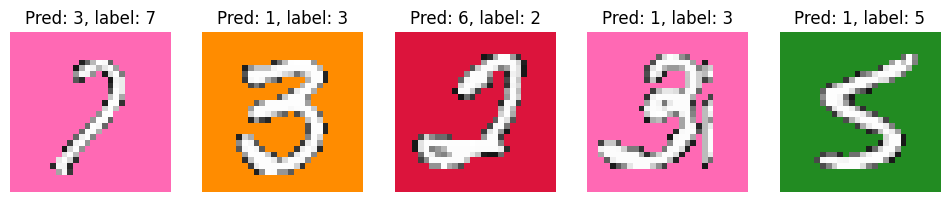

In [307]:
# Load the images in data/MNIST/challenge/ and plot them. Label of the image is the last character of the filename.
challenge_dir = Path('../data/MNIST/challenge')
image_files = list(challenge_dir.glob('*.png'))
fig, axes = plt.subplots(1, len(image_files), figsize=(12,4))
for ax, img_file in zip(axes, image_files):
    img = to_tensor(Image.open(img_file)).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        pred = output.argmax(dim=1).item()
    
    ax.imshow(to_pil(img.squeeze().cpu()))
    ax.set_title(f'Pred: {pred}, label: {img_file.stem[-1]}')
    ax.axis('off')
    print(f'{img_file.name}: Pred: {pred}, Label: {img_file.stem[-1]}')
    for i, pred in enumerate(output[0]):
        print(f"Clase: {i}, pred {pred}")
plt.show()

---
### Any code you want to add, put it below this markdown cell

In [308]:
from typing import Optional
import copy

## Métodos de XAI: Smoothgrad, DeconvNet e IntegratedGradients

In [321]:
class SmoothGradSaliencyMap(torch.nn.Module):
    """
    This is the class for computing smoothgrad saliency maps.

    Attr:
        model: model used to classify.
    """

    def __init__(self) -> None:
        """
        Thi function is the constructor for SmoothGradSaliencyMap.

        Args:
            model: model used to classify.

        Returns:
            None.
        """

        # call super class constructor
        super().__init__()

    def forward(
        self,
        inputs: torch.Tensor,
        model: torch.nn.Module,
        noise_level: float,
        sample_size: int,
    ) -> torch.Tensor:
        return self.explain(inputs, model, noise_level, sample_size)

    @torch.no_grad()
    def explain(
        self,
        inputs: torch.Tensor,
        model: torch.nn.Module,
        noise_level: float,
        sample_size: int,
    ) -> torch.Tensor:
        """
        This method computes the explanation.
        """
        model.eval()
        
        # Ensure all model parameters require gradients
        for param in model.parameters():
            param.requires_grad_(True)
        
        with torch.enable_grad():
            total_gradients: torch.Tensor = torch.zeros_like(inputs)
            
            for i in range(sample_size):
                noise: torch.Tensor = torch.normal(
                    torch.zeros_like(inputs), noise_level
                )
                noisy_input = inputs + noise
                noisy_input = noisy_input.detach()  # Detach first
                noisy_input.requires_grad = True
                
                # Forward pass
                x = model.pool(torch.nn.functional.relu(model.conv1(noisy_input)))
                x = model.pool(x)
                x = x.view(x.size(0), -1)
                x = model.dropout(torch.nn.functional.relu(model.fc1(x)))
                logits = model.fc2(x)

                target_class: torch.Tensor = torch.argmax(logits, dim=-1)
                target_logits: torch.Tensor = logits.gather(
                    1, target_class.unsqueeze(1)
                ).squeeze()

                # Backward pass
                model.zero_grad()  # Clear model gradients
                if noisy_input.grad is not None:
                    noisy_input.grad.zero_()  # Clear input gradients
                
                target_logits.backward()

                gradients: Optional[torch.Tensor] = noisy_input.grad
                
                if gradients is not None:
                    total_gradients += gradients.detach()

            total_gradients *= 1 / sample_size

        output: torch.Tensor = torch.max(torch.abs(total_gradients), dim=1)[0]
        return output


class DeConvNet:
    @torch.no_grad()
    def __init__(self, model: torch.nn.Module) -> None:
        """
        This is the constructor for DeConvNet.

        Args:
            model: model used to classify.
        """

        # set attributes
        self.model = copy.deepcopy(model)
        self.register_hooks()

    def register_hooks(self) -> None:
        """
        This function registers the hooks needed for deconvnet.

        Returns:
            None.
        """
        def relu_gradient(module, grad_input, grad_output):
            new_gradient: torch.Tensor = torch.clamp(grad_output[0], min=0.0)
            return (new_gradient,)

        for module in self.model.modules():
            if isinstance(module, torch.nn.ReLU):
                module.register_full_backward_hook(relu_gradient)

    def explain(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        This method computes the explanation.

        Args:
            inputs: inputs tensor. Dimensions: [batch, channels,
                height, width].

        Raises:
            RuntimeError: No gradients were computed during the
                backward pass.

        Returns:
            saliency maps tensor. Dimensions: [batch, height, width].
        """

        inputs.requires_grad = True
        x = model.pool(torch.nn.functional.relu(model.conv1(inputs)))
        x = model.pool(x)
        x = x.view(x.size(0), -1)
        x = model.dropout(torch.nn.functional.relu(model.fc1(x)))
        logits = model.fc2(x)

        target_class: torch.Tensor = torch.argmax(logits, dim=-1)
        target_logits: torch.Tensor = logits.gather(
            1, target_class.unsqueeze(1)
        ).squeeze()

        target_logits.backward(torch.ones_like(target_logits))
        if inputs.grad is not None:
            gradients: torch.Tensor = inputs.grad
            output: torch.Tensor = gradients.max(dim=1)[0]
        else:
            raise ValueError("Gradient is None.")
        return output
    


class IntegratedGradients(torch.nn.Module):
    """
    This is the class for computing Integrated Gradients saliency maps.
    """

    def __init__(self) -> None:
        """
        Constructor for IntegratedGradients.
        """
        super().__init__()

    def forward(
        self,
        inputs: torch.Tensor,
        model: torch.nn.Module,
        baseline: Optional[torch.Tensor] = None,
        steps: int = 50,
    ) -> torch.Tensor:
        return self.explain(inputs, model, baseline, steps)

    @torch.no_grad()
    def explain(
        self,
        inputs: torch.Tensor,
        model: torch.nn.Module,
        baseline: Optional[torch.Tensor] = None,
        steps: int = 50,
    ) -> torch.Tensor:
        """
        Compute the explanation using Integrated Gradients.

        Args:
            inputs: Input tensor. Dimensions: [batch, channels, height, width]
            model: Model to explain
            baseline: Baseline tensor (if None, uses zeros)
            steps: Number of integration steps

        Returns:
            Saliency maps tensor. Dimensions: [batch, height, width]
        """
        
        if baseline is None:
            baseline = torch.zeros_like(inputs)
        
        scaled_inputs = [
            baseline + (float(i) / steps) * (inputs - baseline)
            for i in range(steps + 1)
        ]
        
        with torch.enable_grad():
            grads = []
            for scaled_input in scaled_inputs:
                scaled_input.requires_grad = True
                
                x = model.pool(torch.nn.functional.relu(model.conv1(scaled_input)))
                x = model.pool(x)
                x = x.view(x.size(0), -1)
                x = model.dropout(torch.nn.functional.relu(model.fc1(x)))
                logits = model.fc2(x)
                
                target_class: torch.Tensor = torch.argmax(logits, dim=-1)
                target_logits: torch.Tensor = logits.gather(
                    1, target_class.unsqueeze(1)
                ).squeeze()
                
                target_logits.backward(torch.ones_like(target_logits))
                
                if scaled_input.grad is not None:
                    grads.append(scaled_input.grad)
            
            avg_grads = torch.stack(grads).mean(dim=0)
            
            integrated_grads = (inputs - baseline) * avg_grads
        
        output: torch.Tensor = torch.max(torch.abs(integrated_grads), dim=1)[0]
        return output
    



He utilizado las clases de Smoothgrad y DeconvNet que programamos el año pasado en CV2, ajustándolas al nuevo modelo e imágenes. Al final no me han servido ya que IntegratedGradients funciona bastante mejor. Esta la última la he programado basándome en las dos anteriores.

### Método para plottear los resultados de los tres algoritmos anteriores y tener cierta noción de qué estrategia seguir.

In [322]:
import matplotlib.pyplot as plt
import torch

def plot_xai_results(
    model,
    inputs: torch.Tensor,
    smoothgrad: SmoothGradSaliencyMap,
    deconvnet: DeConvNet,
    integrated: IntegratedGradients,
    noise_level: float = 0.1,
    sample_size: int = 20,
    idx: int = 0,
):
    """
    Plot SmoothGrad and DeConvNet saliency maps for a single image.

    Args:
        model: Trained CNN model.
        inputs: Batch of input images [B, C, H, W].
        smoothgrad: SmoothGradSaliencyMap instance.
        deconvnet: DeConvNet instance.
        noise_level: std of Gaussian noise for SmoothGrad.
        sample_size: number of samples for SmoothGrad.
        idx: index of image in the batch to visualize.
    """
    model.eval()
    device = next(model.parameters()).device
    inputs = inputs.to(device)

    # Select single image   
    img = inputs[idx : idx + 1]

    # --- Compute saliency maps ---
    smoothgrad_map = smoothgrad.explain(img, model, noise_level, sample_size).detach().cpu()
    deconv_map = deconvnet.explain(img).detach().cpu()
    integrated_map = integrated.explain(img, model).detach().cpu()

    def normalize(tensor: torch.Tensor) -> torch.Tensor:
        """
        Normalize a tensor to [0, 1] range safely, without in-place ops.
        """
        tensor = tensor.detach().clone().squeeze()
        min_val = tensor.min()
        max_val = tensor.max()
        return (tensor - min_val) / (max_val - min_val + 1e-8)
    

    # print(smoothgrad_map)

    smoothgrad_map = normalize(smoothgrad_map)
    deconv_map = normalize(deconv_map)
    integrated_map = normalize(integrated_map)

    img_vis = normalize(img.cpu())

    # --- Plot results ---
    fig, axes = plt.subplots(1, 4, figsize=(10, 4))

    axes[0].imshow(img_vis.squeeze().permute(1, 2, 0))
    axes[0].set_title("Original Image")

    axes[1].imshow(smoothgrad_map, cmap="hot")
    axes[1].set_title("SmoothGrad")

    axes[2].imshow(deconv_map, cmap="hot")
    axes[2].set_title("DeConvNet")

    axes[3].imshow(integrated_map, cmap="hot")
    axes[3].set_title("Integrated")


    for ax in axes:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    return smoothgrad_map, deconv_map, integrated_map



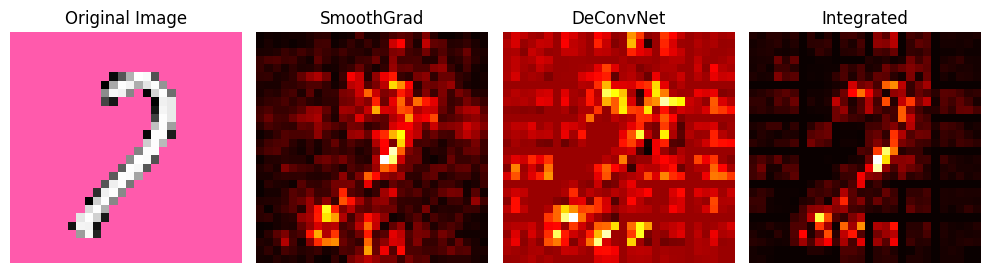

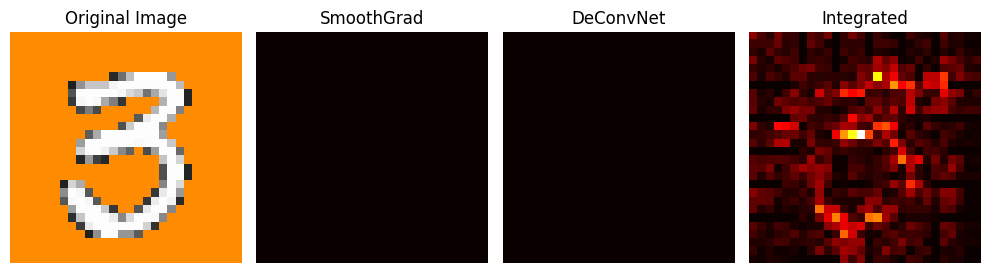

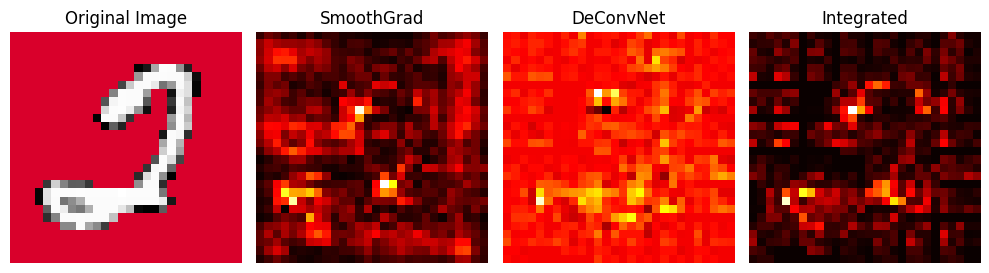

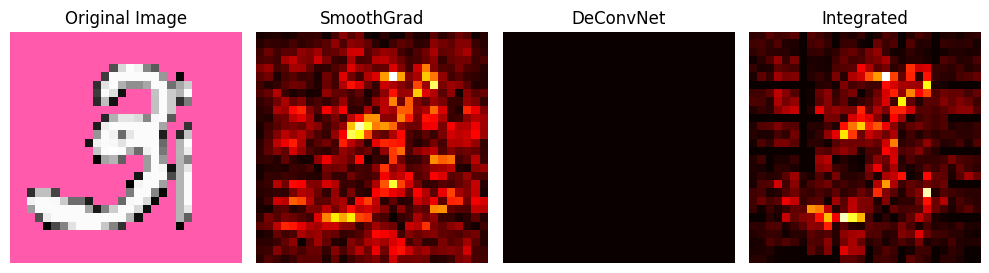

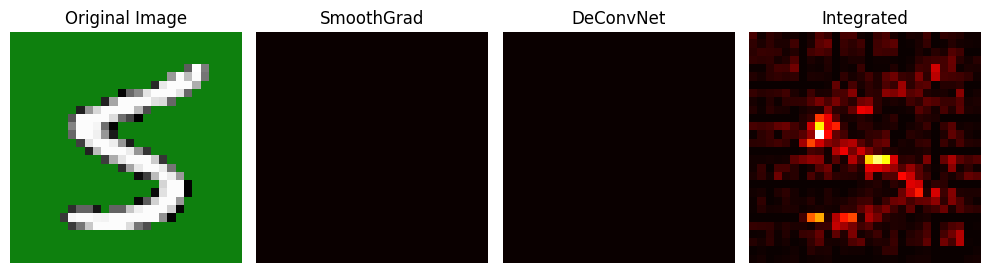

Image 0:
  SmoothGrad top-86 pixels: [(tensor(15), tensor(15)), (tensor(14), tensor(16)), (tensor(15), tensor(16)), (tensor(21), tensor(8)), (tensor(12), tensor(17)), (tensor(22), tensor(8)), (tensor(6), tensor(16)), (tensor(13), tensor(17)), (tensor(12), tensor(16)), (tensor(9), tensor(14)), (tensor(24), tensor(7)), (tensor(26), tensor(13)), (tensor(22), tensor(9)), (tensor(10), tensor(18)), (tensor(6), tensor(17)), (tensor(25), tensor(9)), (tensor(25), tensor(8)), (tensor(8), tensor(19)), (tensor(25), tensor(13)), (tensor(8), tensor(17)), (tensor(23), tensor(13)), (tensor(16), tensor(15)), (tensor(7), tensor(13)), (tensor(17), tensor(13)), (tensor(14), tensor(17)), (tensor(9), tensor(17)), (tensor(20), tensor(10)), (tensor(10), tensor(21)), (tensor(9), tensor(18)), (tensor(24), tensor(9)), (tensor(16), tensor(16)), (tensor(12), tensor(15)), (tensor(25), tensor(7)), (tensor(19), tensor(10)), (tensor(8), tensor(14)), (tensor(21), tensor(9)), (tensor(7), tensor(17)), (tensor(24), tensor

In [323]:
# define ToyModel
noise_level: float = 0.2
sample_size: int = 25

images: list = []

for i in range(len(image_files)):
    images.append(to_tensor(Image.open(image_files[i])).unsqueeze(0).to(device))

images_tensor: torch.Tensor = torch.stack([image.squeeze(0) for image in images])

smoothgrad = SmoothGradSaliencyMap()
deconvnet = DeConvNet(model)
integrated = IntegratedGradients()

important_pixels_smoothgrad: list[list[tuple[int, int]]] = []
important_pixels_deconvnet: list[list[tuple[int, int]]] = []
important_pixels_integrated: list[list[tuple[int, int]]] = []

k: int = 86


for i in range(len(images_tensor)):
    smoothgrad_map, deconvnet_map, integrated_map = plot_xai_results(
        model, images_tensor, smoothgrad, deconvnet, integrated,
        noise_level=0.2, sample_size=20, idx=i
    )

    smoothgrad_map = smoothgrad_map.squeeze().detach().cpu()
    deconvnet_map = deconvnet_map.squeeze().detach().cpu()
    integrated_map = integrated_map.squeeze().detach().cpu()
    

    topk_smoothgrad = torch.topk(smoothgrad_map.flatten(), k)
    topk_deconvnet = torch.topk(deconvnet_map.flatten(), k)
    topk_integrated = torch.topk(integrated_map.flatten(), k)

    coords_smoothgrad = list(zip(*torch.unravel_index(topk_smoothgrad.indices, smoothgrad_map.shape)))
    coords_deconvnet = list(zip(*torch.unravel_index(topk_deconvnet.indices, deconvnet_map.shape)))
    coords_integrated = list(zip(*torch.unravel_index(topk_integrated.indices, integrated_map.shape)))

    important_pixels_smoothgrad.append(coords_smoothgrad)
    important_pixels_deconvnet.append(coords_deconvnet)
    important_pixels_integrated.append(coords_integrated)

for i in range(len(images_tensor)):
    print(f"Image {i}:")
    print(f"  SmoothGrad top-{k} pixels: {important_pixels_smoothgrad[i]}")
    print(f"  DeConvNet top-{k} pixels: {important_pixels_deconvnet[i]}\n")
    print(f"  Integrated top-{k} pixels: {important_pixels_integrated[i]}")

In [312]:
def modify_pixels(image_path, pixel_coords, new_values, output_path=None):
    """
    Modify specific pixels in an image.
    
    Args:
        image_path: Path to the input image or PIL Image object
        pixel_coords: List of tuples [(row, col), (row, col), ...] where row/col are in [0, 27]
        new_values: Single value or list of RGB tuples to set the pixels to, e.g., (255, 255, 255) or [(R,G,B), (R,G,B), ...]
        output_path: Path to save the modified image (if None, returns PIL Image)
    
    Returns:
        PIL Image object
    """
    from PIL import Image
    import numpy as np
    
    # Open image if path is provided
    if isinstance(image_path, (str, Path)):
        img = Image.open(str(image_path)) 
    else:
        img = image_path
    
    # Convert to RGB if not already
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img_array = np.array(img)  # Shape: (28, 28, 3)
    
    # Handle single value or list of values
    if not isinstance(new_values, list):
        new_values = [new_values] * len(pixel_coords)
    
    # Ensure new_values are tuples for RGB
    processed_values = []
    for val in new_values:
        if isinstance(val, (int, float)):
            # If single value, apply to all channels
            processed_values.append((int(val), int(val), int(val)))
        else:
            processed_values.append(tuple(int(v) for v in val))
    
    
    # Modify pixels
    for (row, col), value in zip(pixel_coords, processed_values):
        if 0 <= row < img_array.shape[0] and 0 <= col < img_array.shape[1]:
            img_array[row, col] = value
    
    # Convert back to image
    modified_img = Image.fromarray(img_array.astype(np.uint8))
    
    # Save if output path provided
    if output_path:
        modified_img.save(output_path)
    
    return modified_img

In [313]:
def loop_over_k(k: int, image, model):

        def normalize(tensor: torch.Tensor) -> torch.Tensor:
                """
                Normalize a tensor to [0, 1] range safely, without in-place ops.
                """
                tensor = tensor.detach().clone().squeeze()
                min_val = tensor.min()
                max_val = tensor.max()
                return (tensor - min_val) / (max_val - min_val + 1e-8)

        integrated = IntegratedGradients()
        model.eval()
        integrated_map = integrated.explain(image, model).detach().cpu()
        integrated_map = normalize(integrated_map)
        integrated_map = integrated_map.squeeze().detach().cpu()
        topk_integrated = torch.topk(integrated_map.flatten(), k)
        
        coords_integrated = list(zip(*torch.unravel_index(topk_integrated.indices, integrated_map.shape)))

        return coords_integrated


In [325]:
image_index: int = 1

image_names: list[str] = [
    "0_label5.png",
    "1_label3.png",
    "2_label3.png",
    "3_label7.png",
    "4_label2.png",
]

image_name: str = image_names[image_index]

image_path = challenge_dir / image_name

img_tensor = to_tensor(Image.open(image_path)).unsqueeze(0).to(device)
background_color = (img_tensor.squeeze(0)[0, 0, 0].item() * 255, img_tensor.squeeze(0)[1, 0, 0].item() * 255, img_tensor.squeeze(0)[2, 0, 0].item() * 255)
white_value = (255, 255, 255)
black_value = (0, 0, 0)

colors = (background_color, white_value, black_value)

for k in range(450):
    for color in colors:
        img_tensor = torch.stack([img_tensor.squeeze(0)])
        coords = loop_over_k(k, img_tensor, model)
        modified_img = modify_pixels(
            image_path, 
            coords, 
            color,  # or black_value, or a list of different values
            output_path=challenge_dir / 'edited' / image_name
        )
        original_img = Image.open(image_path)

        if modified_img.mode != 'RGB':
            modified_img = modified_img.convert('RGB')

        img_tensor = to_tensor(modified_img).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        
        if pred == int(image_path.stem[-1]):
            print(k, color)
            assert False

85 (0, 0, 0)


AssertionError: 

In [315]:

important_pixels_integrated_copy = deepcopy(important_pixels_integrated)

important_coords = important_pixels_integrated_copy[image_index]
print(len(important_coords))

modified_img = modify_pixels(
    image_path, 
    important_coords, 
    black_value,
    output_path=challenge_dir / 'edited' / image_name
)
print(f"Modified image {image_name}")

86
Modified image 1_label3.png


---
## Check if you have passed the challenge 

In [316]:
# Check percentage of editing an image
def calculate_edit_percentage(original_img, edited_img):
    original_pixels = original_img.load()
    edited_pixels = edited_img.load()
    width, height = original_img.size
    total_pixels = width * height
    changed_pixels = 0

    for x in range(width):
        for y in range(height):
            if original_pixels[x, y] != edited_pixels[x, y]:
                changed_pixels += 1

    return (changed_pixels / total_pixels) * 100

In [326]:
# Create edited directory
edited_dir = challenge_dir / 'edited'

# Load edited images, check that they are predicted correctly and calculate edit percentages
for original_img_file, edited_img_file in zip(challenge_dir.glob('*.png'), edited_dir.glob('*.png')):
    original_img = Image.open(original_img_file)
    edited_img = Image.open(edited_img_file)
    # Convert the edited image to RGB if it's not
    if edited_img.mode != 'RGB':
        edited_img = edited_img.convert('RGB')

    # Check prediction
    img_tensor = to_tensor(edited_img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()

        
    print(f'Edited {edited_img_file.name}: Pred: {pred}, Label: {original_img_file.stem[-1]}, correct: {pred == int(original_img_file.stem[-1])}')
    # Calculate edit percentage
    edit_percentage = calculate_edit_percentage(original_img, edited_img)
    print(f'Edit Percentage: {edit_percentage:.2f}%')
    #

Edited 3_label7.png: Pred: 7, Label: 7, correct: True
Edit Percentage: 25.38%
Edited 1_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 10.84%
Edited 4_label2.png: Pred: 2, Label: 2, correct: True
Edit Percentage: 38.27%
Edited 2_label3.png: Pred: 3, Label: 3, correct: True
Edit Percentage: 18.75%
Edited 0_label5.png: Pred: 5, Label: 5, correct: True
Edit Percentage: 20.28%


Para la imagen 4, cuyo label es 2, he visto los píxeles que más influencia tenían en Integrated Gradients y los he apagado. Esto se debe a que el dos dibujado tiene una forma rara, no muy parecida a un dos, por lo que he pensado que sería conveniente quitar parte de esa estructura completamente y dejar solo los trozos que de verdad corresponden a un dos. Así, considero que los píxeles más importantes para Integrated Gradients son los que al final están provocando que la predicción no sea la correcta.

La misma estrategia se ha seguido con la imagen 3, con label 7, pero en este caso encendiendo (poniendo en blanco) en vez de apagando. Fijándonos en el resultado de integrated gradients, vemos que se puede intuir cierta concentración de píxeles importantes en medio del siete, donde normalmente habría un palito horizontal que no está presente en esta imagen. Por ello, al pintarlo con los píxeles proporcionados por integrated gradients, el resultado se acerca ligeramente más a ser un siete, a pesar de que también se pintan muchos otros píxeles, por lo que la predicción termina siendo correcta.

Para la imagen 2, con label 3, se ha vuelto a seguir la misma estrategia con Integrated Gradients. Sin embargo, en este caso se han rellenado los 450 píxeles más importantes con el color de fondo, de modo que solo ha quedado un ligero rastro de lo que originalmente era un tres. He decidido hacer esto porque en la imagen original, el tres tiene una línea vertical que sobre completamente cuya eliminación podía ser beneficiosa.

Para la imagen 1, de label 3, después de probar con muchísimas combinaciones de píxeles y colores, he decidio utilizar un algoritmo de fuerza bruta que pruebe si cambiando el color de los k píxeles más importantes se consigue acertar la predicción, y ha funcionado. Apagando los 85 píxeles más importantes funciona. Lo mismo se ha hecho para la imagen 0, de label 5, donde hace faltar apagar los 159 píxeles más importantes.
Para estas dos últimas imágenes, es necesario ejecutar el bucle sobre k (look_over_k) y después evaluar las predicciones, ya que el bucle deja como imagen modificada la imagen que da una predicción buena.